In [2]:
# Importing the necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from sklearn import linear_model

# Importing the csv data and exploring the data structure
df = pd.read_csv("cohort_revenue_regression_data.csv")
df.head()

,week,platform,media_spend,installs,total_registrations,first_registrations,d8_revenue,m0_revenue,m6_revenue,m12_revenue,m24_revenue
0,2021-04-05 00:00:00,iOS,17744.2143,19282,13627,13626,19107.70,23095.70,68399.4500,96566.5600,134821.2100
1,2021-04-12 00:00:00,iOS,17970.8000,24493,13986,13978,22562.96,27456.11,71626.3000,101203.2700,143166.2400
2,2021-04-19 00:00:00,iOS,18149.8986,26866,14861,14853,23897.57,29082.96,74534.4899,103397.5299,143680.4999
3,2021-04-26 00:00:00,iOS,20307.6043,25936,14166,14098,26836.62,31450.17,74501.4000,103748.8900,143229.5200
4,2021-05-03 00:00:00,iOS,20699.5143,26094,13813,13787,23310.88,27562.54,72445.2296,102367.0191,139906.8887


In [3]:
# Let's create separate datasets for training and testing as well as the production predictions eventually
train_df = df[df["week"] < "2023-01-02"]
test_df = df[(df["week"] >= "2023-01-02") & (df["week"] <= "2023-03-14")]
prod_df = df[df["week"] > "2023-03-14"]
print("Training Model count: " + str(train_df["week"].count()))
print("Testing Model count: " + str(test_df["week"].count()))
print("Production Model count: " + str(prod_df["week"].count()))

Training Model count: 91
Testing Model count: 11
Production Model count: 53


                             OLS Regression Results                            
Dep. Variable:     total_registrations   R-squared:                       0.798
Model:                             OLS   Adj. R-squared:                  0.795
Method:                  Least Squares   F-statistic:                     350.8
Date:                 Wed, 10 Apr 2024   Prob (F-statistic):           1.25e-32
Time:                         15:21:50   Log-Likelihood:                -787.34
No. Observations:                   91   AIC:                             1579.
Df Residuals:                       89   BIC:                             1584.
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -439.0082    965.981     -0.45

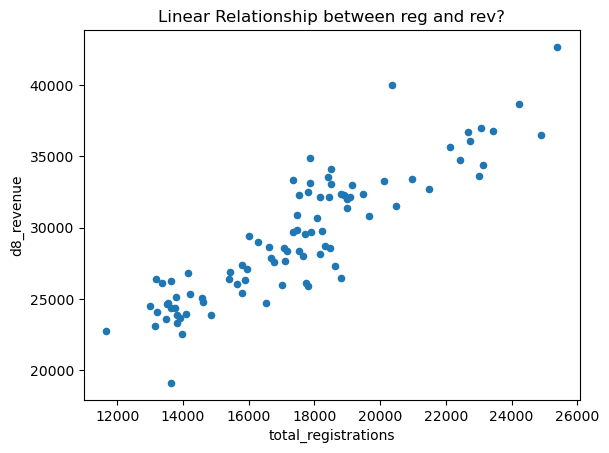

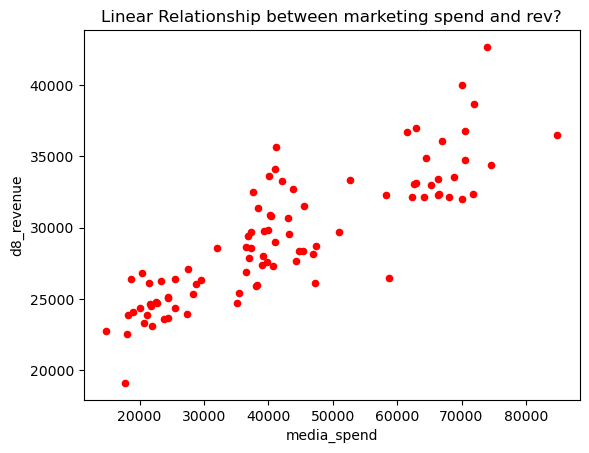

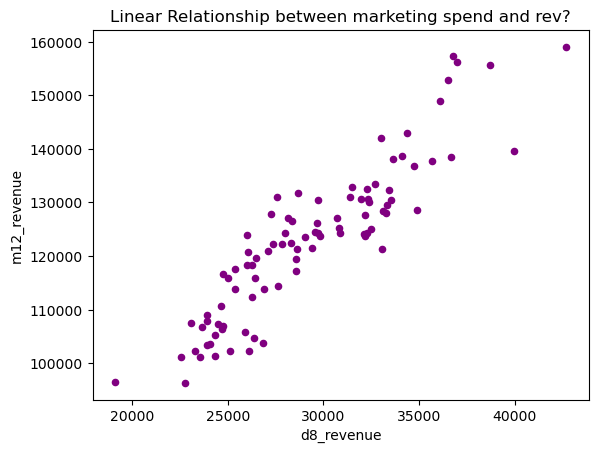

In [4]:
### Checking for Linear Relationships
# First, let's look for a linear relationship using a scatterplot
train_df.plot(x="total_registrations",y="d8_revenue",kind="scatter",title="Linear Relationship between reg and rev?")

# Next let's check for linearity using OLS R-squared

# Create a model and save it to the object
model1 = smf.ols("total_registrations ~ d8_revenue", data = train_df).fit()

# Visualize the summary/output of the regression
print(model1.summary())

## We'll do the same thing for the the relationship between media spend and d8_revenue
train_df.plot(x="media_spend",y="d8_revenue",kind="scatter",color = 'red',title="Linear Relationship between marketing spend and rev?") 

# Create a model and save it to the object
model2 = smf.ols("media_spend ~ d8_revenue", data = train_df).fit()

# Visualize the summary/output of the regression
print(model2.summary())

## Lastly, let's check for linearity between d8_revenue and m12_revenue
train_df.plot(x="d8_revenue",y="m12_revenue",kind="scatter",color = 'purple',title="Linear Relationship between marketing spend and rev?") 

# Create a model and save it to the object
model3 = smf.ols("d8_revenue ~ m12_revenue", data = train_df).fit()

# Visualize the summary/output of the regression
print(model3.summary())

In [7]:
#### CREATING THE MULTIVARIATE LINEAR REGRESSION MODEL

X = train_df[['media_spend', 'total_registrations', 'd8_revenue']]
y = train_df['m12_revenue']

regr = linear_model.LinearRegression()
regr.fit(X, y)

train_df['pred_m12_rev'] == regr.predict(X)

# Variance Score: 1 means perfect Prediction
variance_score = regr.score(X,y)
print("Coefficient of Determination for Model: " + str(variance_score))
intercept = (regr.intercept_)
print("Slope of line in Model: " + str(intercept))
coefs = regr.coef_
print("Coefficients of variables: " + str(coefs))

Coefficient of Determination for Model: 0.8818921844664511
Slope of line in Model: 42074.17130812374
Coefficients of variables: [0.03061506 2.39034124 1.28643872]


In [11]:
# Calculating the accuracy of the model on the TRAINING dataset

# Creating some basic building blocks for the variance calculations
train_dollar_dff = train_df['pred_m12_rev'] - train_df['m12_revenue']
train_pct_diff = ((train_df['pred_m12_rev'] - train_df['m12_revenue'])/(train_df['m12_revenue']))*100
train_count = train_df['pred_m12_rev'].count()
train_less_than_three = (train_pct_diff <= 3).sum()
train_less_than_five = (train_pct_diff <= 5).sum()
train_less_than_ten = (train_pct_diff <= 10).sum()
train_three_pct = round((train_less_than_three/train_count)*100,2)
train_five_pct = round((train_less_than_five/train_count)*100,2)
train_ten_pct = round((train_less_than_ten/train_count)*100,2)

# Summary of TRAINING Model Accuracy
print( )
print("Summary of TRAINING Model Accuracy:")
print("Count of Total Observations in Model: " + str(train_count))
print("Total # of predictions <= 10% variance= " + str(train_less_than_ten) + "; " + str(train_ten_pct) + "% of observations")
print("Total # of predictions <= 5% variance= " + str(train_less_than_five) + "; " + str(train_five_pct) + "% of observations")
print("Total # of predictions <= 3% variance= " + str(train_less_than_three) + "; " + str(train_three_pct) + "% of observations")
print( )

# Summary Stats on quality of TRAINING Predictions
print("Summary Stats on quality of TRAINING Predictions:")
print("Mean: " + str(round(train_pct_diff.mean(),2)))
print("Median: " + str(round(train_pct_diff.median(),2)))
print("Std: " + str(round(train_pct_diff.std(),2)))
print("Min: " + str(round(train_pct_diff.min(),2)))
print("Max: " + str(round(train_pct_diff.max(),2)))


Summary of TRAINING Model Accuracy:
Count of Total Observations in Model: 91
Total # of predictions <= 10% variance= 90; 98.9% of observations
Total # of predictions <= 5% variance= 82; 90.11% of observations
Total # of predictions <= 3% variance= 66; 72.53% of observations

Summary Stats on quality of TRAINING Predictions:
Mean: 0.16
Median: 0.11
Std: 4.01
Min: -9.27
Max: 12.56


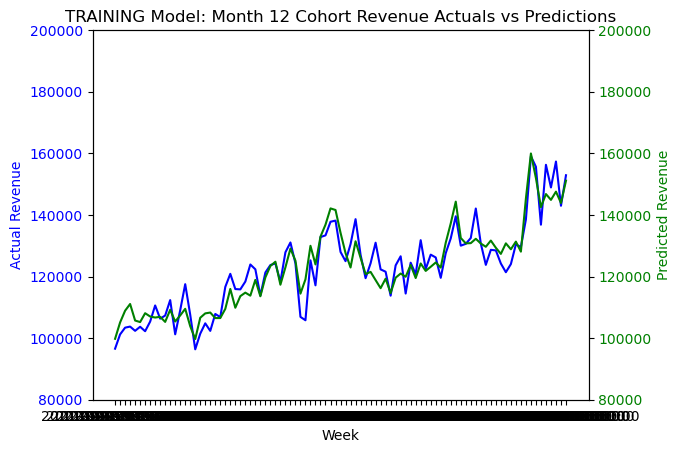

In [12]:
# COMPARING ACTUALS VS PREDICTIONS - TRAINING DATA SET

# Create a basic line plot for the Actuals
fig, ax1 = plt.subplots()
ax1.plot(train_df['week'], train_df['m12_revenue'], color='blue', label='Actuals')
ax1.set_xlabel('Week')
ax1.set_ylabel('Actual Revenue', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a twin axis for the Predictions
ax2 = ax1.twinx()
ax2.plot(train_df['week'], train_df['pred_m12_rev'], color='green', label='Predictions')
ax2.set_ylabel('Predicted Revenue', color='green')
ax2.tick_params(axis='y', labelcolor='green')

# set the same limits for both axis
a,b = 80000,200000
ax1.set_ylim(a,b)
ax2.set_ylim(a,b)

# Add a title and show the plot
plt.title('TRAINING Model: Month 12 Cohort Revenue Actuals vs Predictions')
plt.show()

In [28]:
# Not bad so far.  Let's see how this works on the test dataset.

# Establishing the test variables for the formula:
intercept == regr.intercept_
x1_coef == regr.coef_[0]
x2_coef == regr.coef_[1]
x3_coef == regr.coef_[2]

test_df['pred_m12_rev'] == intercept + (x1_coef * test_df['media_spend']) + (x2_coef * test_df['total_registrations']) + (x3_coef * test_df['d8_revenue'])

# print(test_df)

91     True
92     True
93     True
94     True
95     True
96     True
97     True
98     True
99     True
100    True
101    True
dtype: bool

In [22]:
### Calculating the accuracy of the model on the TESTING dataset

# Creating some basic building blocks for the variance calculations
test_dollar_dff = test_df['pred_m12_rev'] - test_df['m12_revenue']
test_pct_diff = ((test_df['pred_m12_rev'] - test_df['m12_revenue'])/(test_df['m12_revenue']))*100
test_count = test_df['pred_m12_rev'].count()
test_less_than_three = (test_pct_diff <= 3).sum()
test_less_than_five = (test_pct_diff <= 5).sum()
test_less_than_ten = (test_pct_diff <= 10).sum()
test_three_pct = round((test_less_than_three/test_count)*100,2)
test_five_pct = round((test_less_than_five/test_count)*100,2)
test_ten_pct = round((test_less_than_ten/test_count)*100,2)

# Summary of TESTING Model Accuracy
print( )
print("Summary of TESTING Model Accuracy:")
print("Count of Total Observations in Model: " + str(test_count))
print("Total # of predictions <= 10% variance= " + str(test_less_than_ten) + "; " + str(test_ten_pct) + "% of observations")
print("Total # of predictions <= 5% variance= " + str(test_less_than_five) + "; " + str(test_five_pct) + "% of observations")
print("Total # of predictions <= 3% variance= " + str(test_less_than_three) + "; " + str(test_three_pct) + "% of observations")
print( )

# Summary Stats on quality of TESTING Predictions
print("Summary Stats on quality of TESTING Predictions:")
print("Mean: " + str(round(test_pct_diff.mean(),2)))
print("Median: " + str(round(test_pct_diff.median(),2)))
print("Std: " + str(round(test_pct_diff.std(),2)))
print("Min: " + str(round(test_pct_diff.min(),2)))
print("Max: " + str(round(test_pct_diff.max(),2)))


Summary of TESTING Model Accuracy:
Count of Total Observations in Model: 11
Total # of predictions <= 10% variance= 11; 100.0% of observations
Total # of predictions <= 5% variance= 11; 100.0% of observations
Total # of predictions <= 3% variance= 11; 100.0% of observations

Summary Stats on quality of TESTING Predictions:
Mean: -3.05
Median: -3.22
Std: 2.52
Min: -6.94
Max: 1.35


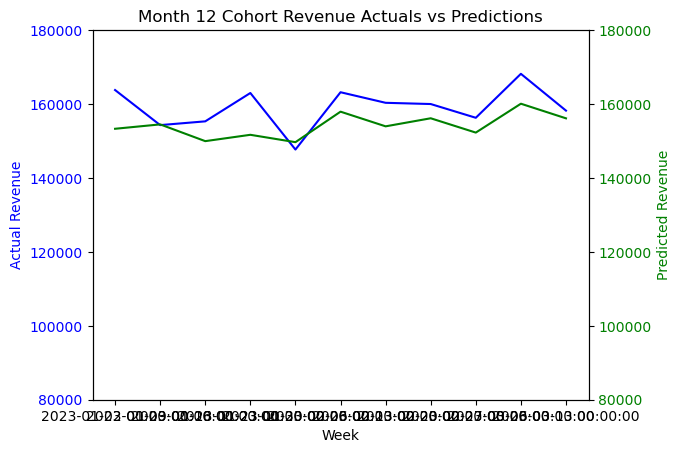

In [23]:
### COMPARING ACTUALS VS PREDICTIONS - TEST DATA SET

# Create a basic line plot for the Actuals
fig, ax1 = plt.subplots()
ax1.plot(test_df['week'], test_df['m12_revenue'], color='blue', label='Actuals')
ax1.set_xlabel('Week')
ax1.set_ylabel('Actual Revenue', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Create a twin axis for the Predictions
ax2 = ax1.twinx()
ax2.plot(test_df['week'], test_df['pred_m12_rev'], color='green', label='Predictions')
ax2.set_ylabel('Predicted Revenue', color='green')
ax2.tick_params(axis='y', labelcolor='green')

# set the same limits for both axis
a,b = 80000,180000
ax1.set_ylim(a,b)
ax2.set_ylim(a,b)

# Add a title and show the plot
plt.title('Month 12 Cohort Revenue Actuals vs Predictions')
plt.show()

In [25]:
### Now that we've validated the model, we'll generate predictions for future cohorts by creating a .py file for the ETL to leverage.

prod_df["pred_m12_rev"] == intercept + (x1_coef * prod_df['media_spend']) + (x2_coef * prod_df['total_registrations']) + (x3_coef * prod_df['d8_revenue'])
prod_df["version"] == "Alpha"
prod_df["target"] == "d8"
prod_df["horizon"] == "m12"


export_to_py = prod_df[["version","target","horizon","week","pred_m12_rev"]]
print(export_to_py)

    version target horizon                 week   pred_m12_rev
102   Alpha     d8     m12  2023-03-20 00:00:00  157704.719709
103   Alpha     d8     m12  2023-03-27 00:00:00  160824.550855
104   Alpha     d8     m12  2023-04-03 00:00:00  158000.872574
105   Alpha     d8     m12  2023-04-10 00:00:00  167470.547847
106   Alpha     d8     m12  2023-04-17 00:00:00  169768.964080
107   Alpha     d8     m12  2023-04-24 00:00:00  173021.126445
108   Alpha     d8     m12  2023-05-01 00:00:00  166422.507600
109   Alpha     d8     m12  2023-05-08 00:00:00  163812.329551
110   Alpha     d8     m12  2023-05-15 00:00:00  167810.037591
111   Alpha     d8     m12  2023-05-22 00:00:00  166281.707472
112   Alpha     d8     m12  2023-05-29 00:00:00  166687.698270
113   Alpha     d8     m12  2023-06-05 00:00:00  173206.949322
114   Alpha     d8     m12  2023-06-12 00:00:00  170006.945082
115   Alpha     d8     m12  2023-06-19 00:00:00  174679.509581
116   Alpha     d8     m12  2023-06-26 00:00:00  176419